In [125]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

% matplotlib inline

We wish to solve:
\begin{align}
q + u' = 0 \\
q' = 0 \\
u(0) = \alpha, \hspace{3mm} u(1) = \beta
\end{align}
Which has the simple solution:
\begin{align}
u = \alpha + (\beta - \alpha)x\\
q = \alpha - \beta
\end{align}

We'll solve this by dividing the unit interval up into two elements, $E1 = (0,1/2)$ and $E2 = (1/2, 1)$

In [126]:
nodes,weights = np.polynomial.legendre.leggauss(3)

def gamma_0(u):
    return 0.5*u**2 - 0.5*u

def gamma_1(u):
    return 1 - u**2

def gamma_2(u):
    return 0.5*u**2 + 0.5*u

def dgamma_0_du(u):
    return u - 0.5

def dgamma_1_du(u):
    return -2*u

def dgamma_2_du(u):
    return u + 0.5


def gamma_inner():
    A = np.zeros((3,3))
    A[0,0] =  np.sum(weights*gamma_0(nodes)*gamma_0(nodes))
    A[0,1] = np.sum(weights*gamma_0(nodes)*gamma_1(nodes))
    A[0,2] = np.sum(weights*gamma_0(nodes)*gamma_2(nodes))
    A[1,1] = np.sum(weights*gamma_1(nodes)*gamma_1(nodes))
    A[1,2] = np.sum(weights*gamma_1(nodes)*gamma_2(nodes))
    A[2,2] = np.sum(weights*gamma_2(nodes)*gamma_2(nodes))
    
    A = A + A.T - np.diag(np.diag(A))
    return A

def gamma_inner_dx():
    A = np.zeros((3,3))
    A[0,0] = np.sum(weights*gamma_0(nodes)*dgamma_0_du(nodes))
    A[0,1] = np.sum(weights*gamma_1(nodes)*dgamma_0_du(nodes))
    A[0,2] = np.sum(weights*gamma_2(nodes)*dgamma_0_du(nodes))
    A[1,0] = np.sum(weights*gamma_0(nodes)*dgamma_1_du(nodes))
    A[1,1] = np.sum(weights*gamma_1(nodes)*dgamma_1_du(nodes))
    A[1,2] = np.sum(weights*gamma_2(nodes)*dgamma_1_du(nodes))
    A[2,0] = np.sum(weights*gamma_0(nodes)*dgamma_2_du(nodes))
    A[2,1] = np.sum(weights*gamma_1(nodes)*dgamma_2_du(nodes))
    A[2,2] = np.sum(weights*gamma_2(nodes)*dgamma_2_du(nodes))
    return A



We divide this into two parts (would be three parts if the right hand side were non-homogeneous).  First, we solve the BVP on each element, keeping the boundary conditions, and assuming that the value of $u$ at the interface is zero.  This gives a solution pair $q_b, u_b$

In [155]:
# solve for boundary values
# left element
M = np.zeros((4,4))
M[0:3,0:3] += 0.25*gamma_inner()
M[:-1,-1] -= gamma_inner_dx()[:,1]
M[-1,:-1] -= gamma_inner_dx()[1,:]
b = np.zeros(4,)

alpha = 0

b[0] += alpha
b[0:3] += alpha*gamma_inner_dx()[:,0]

# right element
M2 = np.zeros((4,4))
M2[0:3,0:3] += 0.25*gamma_inner()
M2[:-1,-1] -= gamma_inner_dx()[:,1]
M2[-1,:-1] -= gamma_inner_dx()[1,:]
b2 = np.zeros(4,)

beta = 1

b2[2] -= beta
b2[0:3] += beta*gamma_inner_dx()[:,2]

In [156]:
qu_g_1 = la.solve(M,b)
qu_g_2 = la.solve(M2,b2)

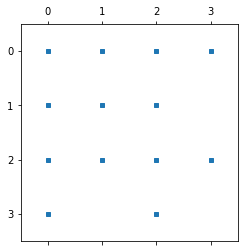

In [168]:
plt.spy(M,markersize=4)

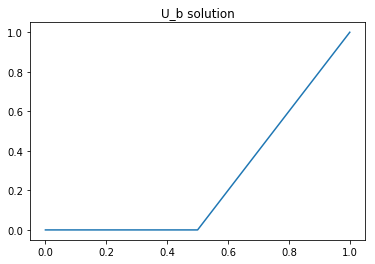

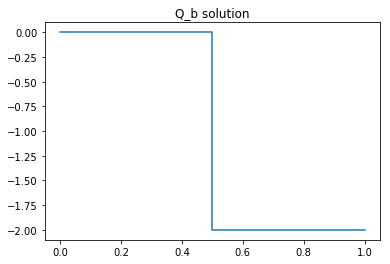

In [157]:
uplot = np.array([alpha, qu_g_1[-1],0,qu_g_2[-1],beta])
xu = np.array([0,0.25,0.5,0.75,1.0])
xq = np.array([0.0,0.25,0.5,0.5,0.75,1.0])
qplot = np.hstack([qu_g_1[0:3],qu_g_2[0:3]])

plt.plot(xu,uplot,label = 'U')
plt.title('U_b solution')
plt.figure()
plt.plot(xq,qplot,label = 'qb')
plt.title('Q_b solution')

Now, we need to solve for the interior value of $u$, and we will do this by strongly enforcing continuity of $q$ along the interface (this enforcement is a specific choice).  We'll set the value at 1, (a basis for $\mathbb{R}^n$) and solve for the solutions $u_1$ and $q_1$

In [158]:
# next, for interior value - solve for "basis" (the number 1)

# 1st element
M3 = np.zeros((4,4))
M3[0:3,0:3] += 0.25*gamma_inner()
M3[:-1,-1] -= gamma_inner_dx()[:,1]
M3[-1,:-1] -= gamma_inner_dx()[1,:]

b3 = np.zeros(4,)
b3[2] -= 1
b3[0:3] += gamma_inner_dx()[:,2]

Q_1_1 = la.solve(M3,b3)

# 2nd element
M4 = np.zeros((4,4))
M4[0:3,0:3] += 0.25*gamma_inner()
M4[:-1,-1] -= gamma_inner_dx()[:,1]
M4[-1,:-1] -= gamma_inner_dx()[1,:]

b4 = np.zeros(4,)
b4[0] += 1
b4[0:3] += gamma_inner_dx()[:,0]

Q_1_2 = la.solve(M4,b4)

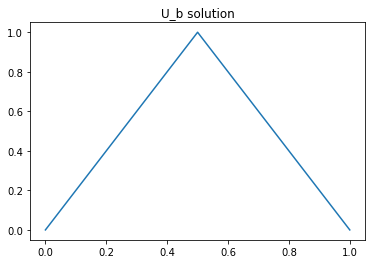

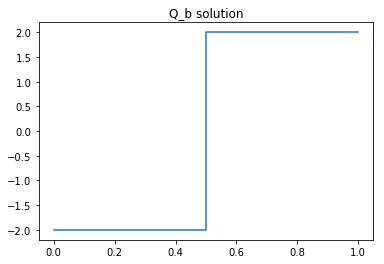

In [159]:
uplot = np.array([0, Q_1_1[-1],1,Q_1_2[-1],0])
xu = np.array([0,0.25,0.5,0.75,1.0])
xq = np.array([0.0,0.25,0.5,0.5,0.75,1.0])
qplot = np.hstack([Q_1_1[0:3],Q_1_2[0:3]])

plt.plot(xu,uplot,label = 'U')
plt.title('U_b solution')
plt.figure()
plt.plot(xq,qplot,label = 'qb')
plt.title('Q_b solution')

Now, the interior value is not necessarily 1.0.  By enforcing continuity of $q$ we can solve for the interior point $\lambda = u(1/2)$

In [160]:
# now solve for the interior point of U
a = 0.25*np.dot(Q_1_1[0:3],np.dot(gamma_inner(),Q_1_1[0:3])) +\
    0.25*np.dot(Q_1_2[0:3],np.dot(gamma_inner(),Q_1_2[0:3]))
    
bb = -alpha*Q_1_1[0] + beta*Q_1_2[2]

u_int = bb/a

Now, we simply add $u = u_b + \lambda u_1$ and $q = q_b + \lambda q_1$

In [161]:
u = np.zeros(5,)
u[0] = alpha
u[-1] = beta
u[2] = u_int
u[1] = qu_g_1[-1] + u_int*Q_1_1[-1]
u[3] = qu_g_2[-1] + u_int*Q_1_2[-1]

q = np.zeros(6,)
q[0:3] = qu_g_1[0:3] + u_int*Q_1_1[0:3]
q[3:] = qu_g_2[0:3] + u_int*Q_1_2[0:3]

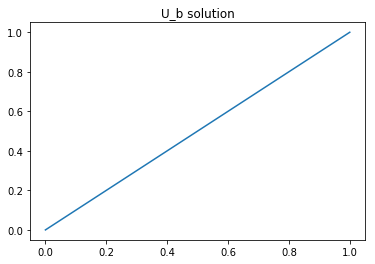

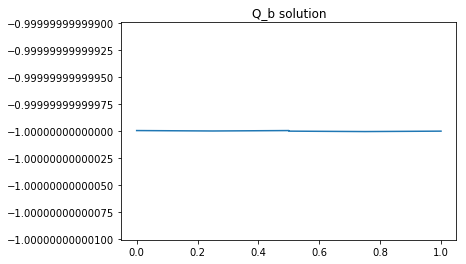

In [163]:
xu = np.array([0,0.25,0.5,0.75,1.0])
xq = np.array([0.0,0.25,0.5,0.5,0.75,1.0])

plt.figure()
plt.plot(xu,u,label = 'U')
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title('U_b solution')
plt.figure()
plt.plot(xq,q,label = 'qb')
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title('Q_b solution')

In [147]:
ax.set_autoscale_on(False)

In [98]:
u

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ])

In [43]:
-Q_1_1[0] + Q_1_2[2]

3.9999999999999889